# Planning experiment

This notebook reproduces the Planning experiment from the STOMP paper.

As in the implementation from the paper, the TwoRooms environment has 72 states, the 72 non-terminal grid cells.

_Disclaimer: we are not yet implementing planning with shortest-path option_

In [ ]:
""" Imports """
import numpy as np

from gridworld.gridworld import GridWorld
from gridworld.room_design import stomp_two_room_design
from stomp.framework import STOMP


In [2]:
%load_ext autoreload
%autoreload 1
%aimport gridworld.gridworld
%aimport stomp.framework
%aimport stomp.steps.model_learning

In [3]:
""" Experiment Parameters """

runs = 1
number_of_lookaheads = 6000
subgoal_state_idx = 30  # this is the hallway state in the TwoRooms
subgoal_idx = 0  # we are learning only one option in this example

env = GridWorld(room_array=stomp_two_room_design)

env.num_states

load_option_and_models = True

In [4]:

if not load_option_and_models:
    raise NotImplementedError()

else:
    from common.utils import load_model

    # value function and policy
    option_w = load_model("w_reward_respecting_hallway_option.npy")
    option_theta = load_model("theta_reward_respecting_hallway_option.npy")

    # reward models
    option_w_rewards_up = load_model("w_rewards_up_option.npy")
    option_w_rewards_down = load_model("w_rewards_down_option.npy")
    option_w_rewards_left = load_model("w_rewards_left_option.npy")
    option_w_rewards_right = load_model("w_rewards_right_option.npy")
    option_w_rewards = load_model("w_reward_respecting_hallway_option.npy")

    option_W_transitions_up = load_model("W_transitions_up_option.npy")
    option_W_transitions_down = load_model("W_transitions_down_option.npy")
    option_W_transitions_left = load_model("W_transitions_left_option.npy")
    option_W_transitions_right = load_model("W_transitions_right_option.npy")
    option_W_transitions = load_model("W_transitions_reward_respecting_hallway_option.npy")



state = env.reset()
initial_state_features = env.get_one_hot_state(state)

# Check if the learned option value function is close to the expected value
import math
# assert math.isclose(option_w @ initial_state_features, 0.831, abs_tol=0.05)
# assert math.isclose(option_w_rewards_up @ initial_state_features, 0.0, abs_tol=0.05)
# assert math.isclose(option_w_rewards_down @ initial_state_features, 0.0, abs_tol=0.05)
# assert math.isclose(option_w_rewards_left @ initial_state_features, 0.0, rel_tol=0.05)
# assert math.isclose(option_w_rewards_right @ initial_state_features, -.99, rel_tol=0.05)


In [5]:
""" Run Experiment """

# Store statistics
many_initial_state_estimative_with_option = np.zeros((runs, number_of_lookaheads))
many_initial_state_estimative = np.zeros((runs, number_of_lookaheads))

for i in range(runs):
    print(f"Run {i + 1}/{runs}")

    env.reset()
    _stomp = STOMP(
        env=env,
        subgoal_states_info={subgoal_state_idx: (7, 3)},  # hallway state position in the grid
    )

    # Local access to planning
    planning = _stomp.planning
    # Initialize option with previously learned parameters
    planning.foundation.w_subgoal[subgoal_idx] = option_w
    planning.foundation.theta_subgoal[subgoal_idx] = option_theta

    planning.foundation.w_rewards[0] = option_w_rewards_up
    planning.foundation.w_rewards[1] = option_w_rewards_down
    planning.foundation.w_rewards[2] = option_w_rewards_left
    planning.foundation.w_rewards[3] = option_w_rewards_right
    planning.foundation.w_rewards[4] = option_w_rewards

    planning.foundation.W_transitions[0] = option_W_transitions_up
    planning.foundation.W_transitions[1] = option_W_transitions_down
    planning.foundation.W_transitions[2] = option_W_transitions_left
    planning.foundation.W_transitions[3] = option_W_transitions_right
    planning.foundation.W_transitions[4] = option_W_transitions

    # Plan with option
    initial_state_estimative_with_option = planning.plan_with_options(num_lookahead_operations=number_of_lookaheads)

    # Now, we want to plan with only primitive actions. First, we reset w
    _stomp.stomp_foundation.w = np.zeros(_stomp.stomp_foundation.env.num_states)

    # Now, remove option
    _stomp.stomp_foundation.num_options = _stomp.stomp_foundation.env.num_actions

    # Plan with primitive actions
    planning.foundation.num_options = planning.foundation.env.num_actions
    initial_state_estimative = planning.plan_with_options(num_lookahead_operations=number_of_lookaheads)

    # # Store results
    many_initial_state_estimative[i] = initial_state_estimative
    many_initial_state_estimative_with_option[i] = initial_state_estimative_with_option


Run 1/1


100%|██████████| 6000/6000 [00:00<00:00, 23178.52it/s]


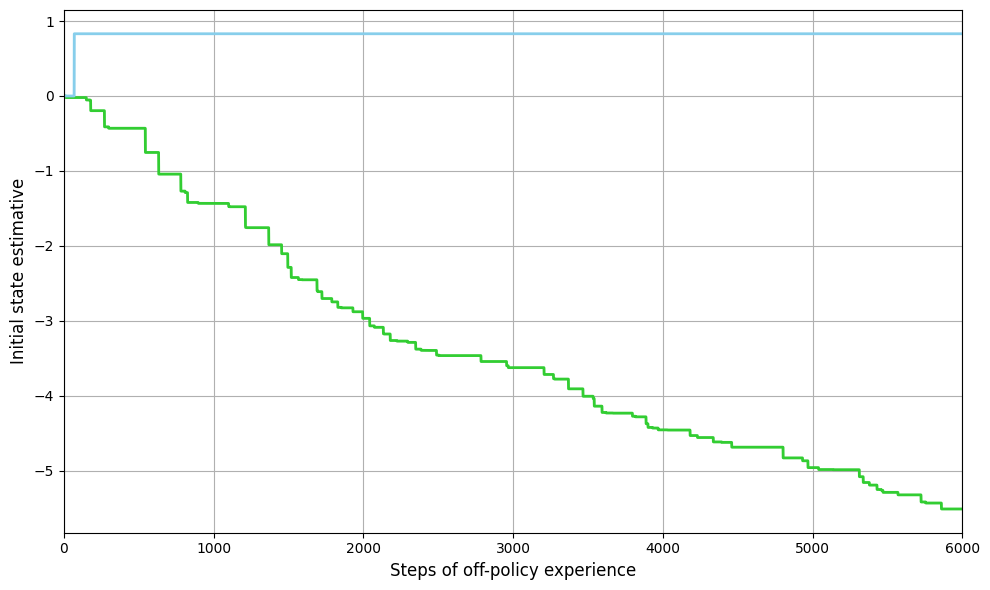

In [7]:
""" Plot Results """

import matplotlib.pyplot as plt

average_initial_state_estimative = np.mean(many_initial_state_estimative, axis=0)
stddev_initial_state_estimative = np.std(many_initial_state_estimative, axis=0)

average_initial_state_estimative_with_option = np.mean(many_initial_state_estimative_with_option, axis=0)
stddev_initial_state_estimative_with_option = np.std(many_initial_state_estimative_with_option, axis=0)

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary axis (left y-axis) for error (red)
ax1.set_xlabel('Steps of off-policy experience', fontsize=12, color='black')
ax1.set_ylabel('Initial state estimative', color='black', fontsize=12)
ax1.plot(range(number_of_lookaheads), average_initial_state_estimative, color='limegreen', linewidth=2)
ax1.fill_between(range(number_of_lookaheads),
                 average_initial_state_estimative - stddev_initial_state_estimative,
                 average_initial_state_estimative + stddev_initial_state_estimative,
                 color='limegreen', alpha=0.2, label='Std Dev (Primitive Actions)')

ax1.plot(range(number_of_lookaheads), average_initial_state_estimative_with_option, color='skyblue', linewidth=2)
ax1.fill_between(range(number_of_lookaheads),
                 average_initial_state_estimative_with_option - stddev_initial_state_estimative_with_option,
                 average_initial_state_estimative_with_option + stddev_initial_state_estimative_with_option,
                 color='skyblue', alpha=0.2, label='Std Dev (With Option)')

ax1.tick_params(axis='y', labelcolor='coral')
ax1.set_xlim(0, number_of_lookaheads)
# ax1.set_ylim(0, 1.0)
ax1.grid(True)


# Style the plot
for spine in ax1.spines.values():
        spine.set_color('black')

ax1.tick_params(colors='black')
ax1.xaxis.label.set_color('black')

plt.tight_layout()
plt.show()
